# Whoop Fitness Recovery Prediction - Multiclass Classification

This notebook analyzes the Whoop Fitness dataset and builds machine learning models to predict recovery status (Rest/Light, Moderate, Push Hard).

## Table of Contents
1. [Data Loading & Preparation](#data)
2. [Exploratory Data Analysis](#eda)
3. [Feature Importance](#importance)
4. [Baseline Models (Before Tuning)](#baseline)
5. [Hyperparameter Tuning](#tuning)
6. [Tuned Models Evaluation](#tuned)
7. [Before/After Comparison](#comparison)


## 1. Data Loading & Preparation <a name='data'></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("Libraries imported successfully!")


Libraries imported successfully!


In [6]:
# Load dataset with robust path handling
# import os

# possible_paths = [
#     '../data/whoop_fitness_dataset_100k.csv',
#     'data/whoop_fitness_dataset_100k.csv',
#     'whoop_fitness_dataset_100k.csv'
# ]

# file_path = None
# for path in possible_paths:
#     if os.path.exists(path):
#         file_path = path
#         break

# if file_path is None:
#     print(f"Current Working Directory: {os.getcwd()}")
#     raise FileNotFoundError(f"Dataset not found. Tried: {possible_paths}")

# print(f"Loading data from: {file_path}")
# df = pd.read_csv(file_path)
# print(f"Dataset Shape: {df.shape}")
# df.head()

import kagglehub

# Download latest version
path = kagglehub.dataset_download("likithagedipudi/whoop-fitness-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'whoop-fitness-dataset' dataset.
Path to dataset files: /kaggle/input/whoop-fitness-dataset


In [7]:
df = pd.read_csv("/kaggle/input/whoop-fitness-dataset/whoop_fitness_dataset_100k.csv")
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (100000, 39)


,user_id,date,day_of_week,age,gender,weight_kg,height_cm,fitness_level,primary_sport,recovery_score,...,activity_strain,avg_heart_rate,max_heart_rate,activity_calories,hr_zone_1_min,hr_zone_2_min,hr_zone_3_min,hr_zone_4_min,hr_zone_5_min,workout_time_of_day
0,USER_00001,2023-01-01,Sunday,56,Female,53.9,167.2,Beginner,Weight Training,57.8,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,USER_00001,2023-01-02,Monday,56,Female,53.9,167.2,Beginner,Weight Training,62.6,...,7.47,121.2,137.6,371.0,11.9,18.0,15.9,11.6,4.6,Evening
2,USER_00001,2023-01-03,Tuesday,56,Female,53.9,167.2,Beginner,Weight Training,81.5,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,USER_00001,2023-01-04,Wednesday,56,Female,53.9,167.2,Beginner,Weight Training,55.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,USER_00001,2023-01-05,Thursday,56,Female,53.9,167.2,Beginner,Weight Training,62.5,...,15.27,136.4,152.8,623.0,3.7,6.0,13.7,18.6,9.0,Evening


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  100000 non-null  object 
 1   date                     100000 non-null  object 
 2   day_of_week              100000 non-null  object 
 3   age                      100000 non-null  int64  
 4   gender                   100000 non-null  object 
 5   weight_kg                100000 non-null  float64
 6   height_cm                100000 non-null  float64
 7   fitness_level            100000 non-null  object 
 8   primary_sport            100000 non-null  object 
 9   recovery_score           100000 non-null  float64
 10  day_strain               100000 non-null  float64
 11  sleep_hours              100000 non-null  float64
 12  sleep_efficiency         100000 non-null  float64
 13  sleep_performance        100000 non-null  float64
 14  light

In [9]:
df.describe()

,age,weight_kg,height_cm,recovery_score,day_strain,sleep_hours,sleep_efficiency,sleep_performance,light_sleep_hours,rem_sleep_hours,...,activity_duration_min,activity_strain,avg_heart_rate,max_heart_rate,activity_calories,hr_zone_1_min,hr_zone_2_min,hr_zone_3_min,hr_zone_4_min,hr_zone_5_min
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.642950,72.707693,171.754403,65.130442,9.911999,7.296272,82.883422,100.0,4.378101,1.641338,...,27.646820,5.740622,74.555414,84.158187,241.158940,4.492818,6.772501,7.270141,6.550316,2.607983
std,13.257307,13.896367,9.337338,17.698584,4.489623,0.972416,10.222554,0.0,0.603068,0.242734,...,29.018375,6.442949,69.630320,78.495935,299.910276,6.081894,7.527003,8.371101,8.492293,3.829844
min,18.000000,38.100000,149.400000,5.000000,0.000000,4.000000,50.000000,100.0,2.240000,0.810000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,62.900000,165.300000,52.400000,6.650000,6.650000,76.500000,100.0,3.980000,1.480000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,72.100000,171.500000,64.500000,9.530000,7.460000,85.000000,100.0,4.460000,1.660000,...,27.000000,2.830000,115.900000,132.400000,84.000000,1.400000,5.000000,5.000000,1.200000,0.000000
75%,53.000000,82.000000,178.900000,77.400000,12.890000,8.030000,90.500000,100.0,4.820000,1.820000,...,51.000000,11.980000,138.400000,156.200000,455.000000,7.300000,12.400000,13.600000,12.400000,4.600000
max,64.000000,115.000000,195.800000,100.000000,21.000000,10.000000,100.000000,100.0,6.210000,2.430000,...,119.000000,21.000000,181.800000,202.000000,1831.000000,45.500000,46.500000,42.900000,46.600000,29.500000


In [10]:
# Check missing values
print("Missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nTotal missing: {df.isnull().sum().sum()}")


Missing values:
workout_time_of_day    45990
dtype: int64

Total missing: 45990


In [11]:
# --- 1. Handling Missing Values ---
# Apply specific logic for workout time: Missing implies no workout occurred
if 'workout_time_of_day' in df.columns:
    print("Before filling:")
    print(df['workout_time_of_day'].value_counts(dropna=False))
    
    df['workout_time_of_day'] = df['workout_time_of_day'].fillna('No Workout')
    
    print("\nAfter filling:")
    print(df['workout_time_of_day'].value_counts())

# Fill remaining numerical NaNs with 0 to prevent LR/MLP crashing
# (e.g., if heart rate zones are NaN, it implies 0 minutes in that zone)
df = df.fillna(0)

Before filling:
workout_time_of_day
NaN          45990
Morning      21505
Afternoon    16258
Evening      16247
Name: count, dtype: int64

After filling:
workout_time_of_day
No Workout    45990
Morning       21505
Afternoon     16258
Evening       16247
Name: count, dtype: int64


### Create Multiclass Target

In [12]:
# Create 3-class target: 0=Rest/Light, 1=Moderate, 2=Push Hard
def create_target(recovery_score):
    if recovery_score < 33:
        return 0  # Rest/Light
    elif recovery_score < 67:
        return 1  # Moderate
    else:
        return 2  # Push Hard

df['target'] = df['recovery_score'].apply(create_target)

# Drop recovery_score to avoid leakage
df = df.drop(columns=['recovery_score'])

print("Target Distribution:")
print(df['target'].value_counts(normalize=True).sort_index())
print(f"\nClass Labels: 0=Rest/Light, 1=Moderate, 2=Push Hard")


Target Distribution:
target
0    0.02717
1    0.52521
2    0.44762
Name: proportion, dtype: float64

Class Labels: 0=Rest/Light, 1=Moderate, 2=Push Hard


### Feature Engineering

In [13]:
# --- Feature Engineering & Preprocessing ---

# 1. Filtering & Outlier Removal
print(f"Shape before filtering: {df.shape}")
if 'sleep_hours' in df.columns:
    df = df[df['sleep_hours'] <= 12]
if 'avg_heart_rate' in df.columns:
    df = df[df['avg_heart_rate'] <= 220]

# Outliers
for col in ['hrv', 'resting_heart_rate', 'day_strain', 'calories_burned']:
    if col in df.columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df = df[(df[col] >= lower) & (df[col] <= upper)]
print(f"Shape after filtering: {df.shape}")

# 2. Text Normalization
if 'gender' in df.columns:
    df['gender'] = df['gender'].str.lower()
if 'fitness_level' in df.columns:
    df['fitness_level'] = df['fitness_level'].str.lower()

# 3. BMI
if 'weight_kg' in df.columns and 'height_cm' in df.columns:
    df['bmi'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)

# 4. Age Group
if 'age' in df.columns:
    bins = [17, 25, 35, 45, 55, 100]
    labels = ['18-25', '26-35', '36-45', '46-55', '56+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels).astype(str)

# 5. Training Load
if 'day_strain' in df.columns and 'activity_strain' in df.columns:
    df['training_load'] = df['day_strain'] + df['activity_strain']

# 6. Sleep Quality Score
cols_sleep = ['sleep_efficiency', 'deep_sleep_hours', 'rem_sleep_hours', 'wake_ups']
if all(c in df.columns for c in cols_sleep):
    df['sleep_quality_score'] = df['sleep_efficiency'] + df['deep_sleep_hours'] + df['rem_sleep_hours'] - (df['wake_ups'] * 0.2)

# 7. HRV / RHR Ratio
if 'hrv' in df.columns and 'resting_heart_rate' in df.columns:
    df['hrv_rhr_ratio'] = df['hrv'] / df['resting_heart_rate']

# 8. Date Features
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month.astype(str)
    df['day_of_week_num'] = df['date'].dt.dayofweek.astype(str)

print("Feature Engineering Complete!")
print(f"Final shape: {df.shape}")


Shape before filtering: (100000, 39)
Shape after filtering: (95123, 39)
Feature Engineering Complete!
Final shape: (95123, 46)


## 2. Exploratory Data Analysis <a name='eda'></a>

### Target Distribution

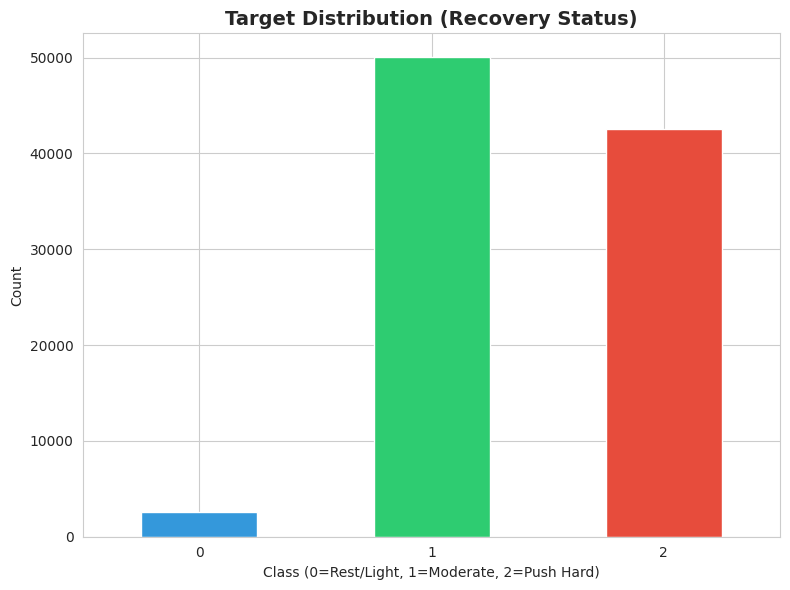

In [14]:
plt.figure(figsize=(8, 6))
df['target'].value_counts().sort_index().plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Target Distribution (Recovery Status)', fontsize=14, fontweight='bold')
plt.xlabel('Class (0=Rest/Light, 1=Moderate, 2=Push Hard)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 3. Feature Importance <a name='importance'></a>

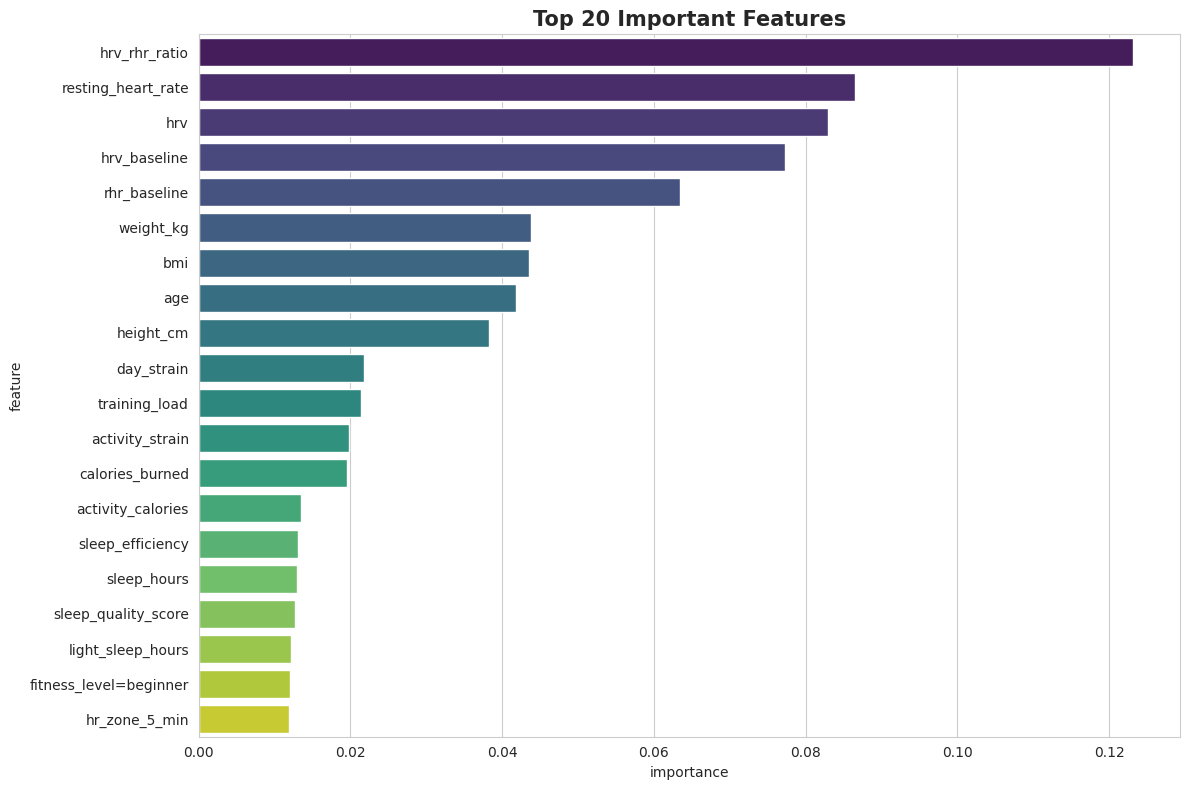

In [15]:
# Prepare data for Random Forest feature importance
drop_cols = ['user_id', 'date', 'target']
X_cols = [c for c in df.columns if c not in drop_cols]
X_imp = df[X_cols].copy()
y_imp = df['target']

# Encode
X_dict = X_imp.to_dict(orient='records')
dv_imp = DictVectorizer(sparse=False)
X_encoded_imp = dv_imp.fit_transform(X_dict)

# Train RF for importance
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_encoded_imp, y_imp)

# Plot
importances = rf.feature_importances_
feature_names = dv_imp.get_feature_names_out()
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')
plt.title('Top 20 Important Features', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


## 4. Baseline Models (Before Tuning) <a name='baseline'></a>

In [16]:
# --- 2. Prepare X and y ---
drop_cols = ['user_id', 'date', 'target']
X_cols = [c for c in df.columns if c not in drop_cols]

# Separate features and target
X_raw = df[X_cols].copy()
y = df['target']

# --- 3. Encoding (DictVectorizer) ---
# Convert dataframe to dict for encoding
# 'No Workout' will now become a specific one-hot encoded feature
X_dict = X_raw.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_encoded = dv.fit_transform(X_dict)

# --- 4. Scaling (StandardScaler) ---
# Essential for Logistic Regression and MLP convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train distribution:\n{pd.Series(y_train).value_counts(normalize=True).sort_index()}")


Train size: (76098, 92), Test size: (19025, 92)
Train distribution:
target
0    0.027057
1    0.526059
2    0.446884
Name: proportion, dtype: float64


In [17]:
# Train baseline models (default parameters)
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_jobs=-1, verbose=-1),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

baseline_results = {}

print("Training Baseline Models...\n")
for name, model in baseline_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    
    baseline_results[name] = {
        'accuracy': acc,
        'auc': auc,
        'model': model,
        'y_pred': y_pred
    }
    
    print(f"  Accuracy: {acc:.4f}, AUC: {auc:.4f}\n")

# Display results table
baseline_df = pd.DataFrame({
    'Model': list(baseline_results.keys()),
    'Accuracy': [r['accuracy'] for r in baseline_results.values()],
    'ROC AUC': [r['auc'] for r in baseline_results.values()]
})
print("\n=== BASELINE RESULTS ===")
print(baseline_df.to_string(index=False))


Training Baseline Models...

Training Logistic Regression...


  Accuracy: 0.7075, AUC: 0.7929

Training LightGBM...
  Accuracy: 0.7275, AUC: 0.8157

Training MLP...
  Accuracy: 0.6981, AUC: 0.7893


=== BASELINE RESULTS ===
              Model  Accuracy  ROC AUC
Logistic Regression  0.707543 0.792914
           LightGBM  0.727516 0.815697
                MLP  0.698134 0.789273


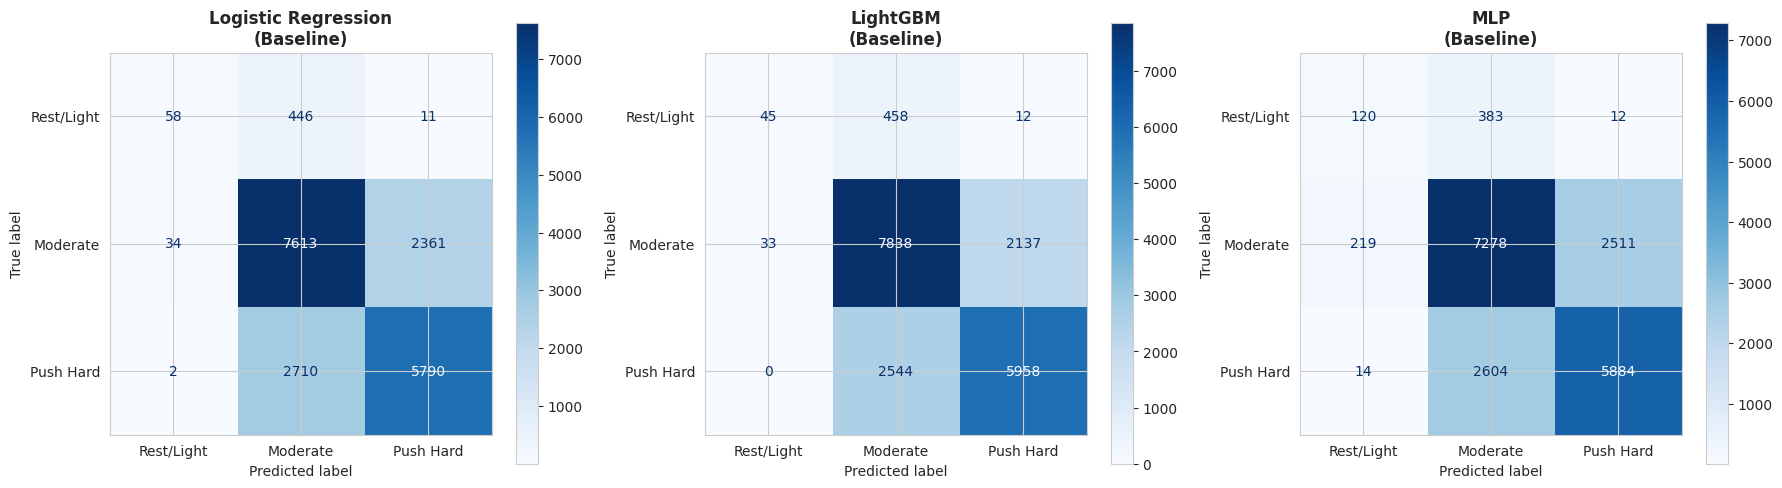

In [18]:
# Confusion matrices for all baseline models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_labels = ['Rest/Light', 'Moderate', 'Push Hard']

for idx, (name, result) in enumerate(baseline_results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}\n(Baseline)', fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Hyperparameter Tuning <a name='tuning'></a>

In [19]:
# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [1000]
    },
    'LightGBM': {
        'num_leaves': [31, 50, 70],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
}

# Initialize fresh models for tuning
tuning_models = {
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_jobs=-1, verbose=-1),
    'MLP': MLPClassifier(random_state=42, max_iter=500)
}

tuned_models = {}
best_params = {}

print("Starting Hyperparameter Tuning...\n")

for name in tuning_models.keys():
    print(f"Tuning {name}...")
    
    # Use RandomizedSearchCV for faster tuning
    search = RandomizedSearchCV(
        tuning_models[name],
        param_grids[name],
        n_iter=10,
        cv=3,
        scoring='roc_auc_ovr_weighted',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    search.fit(X_train, y_train)
    
    tuned_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    
    print(f"  Best Score (CV): {search.best_score_:.4f}")
    print(f"  Best Params: {search.best_params_}\n")

print("Tuning Complete!")


Starting Hyperparameter Tuning...

Tuning Logistic Regression...
  Best Score (CV): 0.7964
  Best Params: {'solver': 'lbfgs', 'max_iter': 1000, 'C': 10}

Tuning LightGBM...
  Best Score (CV): 0.8064
  Best Params: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}

Tuning MLP...
  Best Score (CV): 0.7980
  Best Params: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'relu'}

Tuning Complete!


## 6. Tuned Models Evaluation <a name='tuned'></a>

In [20]:
# Evaluate tuned models
tuned_results = {}

print("Evaluating Tuned Models...\n")
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    
    tuned_results[name] = {
        'accuracy': acc,
        'auc': auc,
        'model': model,
        'y_pred': y_pred,
        'best_params': best_params[name]
    }
    
    print(f"{name}")
    print(f"  Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"  Best Params: {best_params[name]}\n")

# Display results table
tuned_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'Accuracy': [r['accuracy'] for r in tuned_results.values()],
    'ROC AUC': [r['auc'] for r in tuned_results.values()]
})
print("\n=== TUNED RESULTS ===")
print(tuned_df.to_string(index=False))


Evaluating Tuned Models...

Logistic Regression
  Accuracy: 0.7107, AUC: 0.7985
  Best Params: {'solver': 'lbfgs', 'max_iter': 1000, 'C': 10}

LightGBM
  Accuracy: 0.7264, AUC: 0.8150
  Best Params: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}

MLP
  Accuracy: 0.7238, AUC: 0.8119
  Best Params: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'relu'}


=== TUNED RESULTS ===
              Model  Accuracy  ROC AUC
Logistic Regression  0.710749 0.798502
           LightGBM  0.726413 0.814971
                MLP  0.723837 0.811909


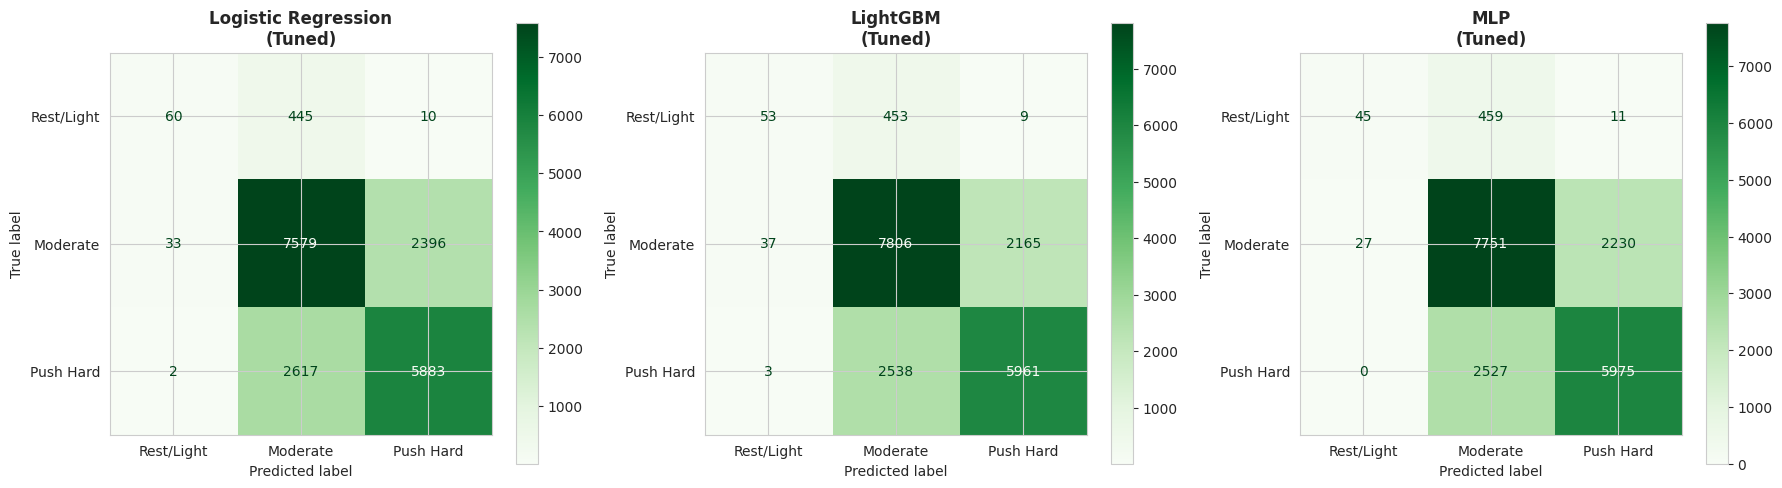

In [21]:
# Confusion matrices for all tuned models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_labels = ['Rest/Light', 'Moderate', 'Push Hard']

for idx, (name, result) in enumerate(tuned_results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[idx], cmap='Greens', values_format='d')
    axes[idx].set_title(f'{name}\n(Tuned)', fontweight='bold')

plt.tight_layout()
plt.show()


## 7. Before/After Comparison <a name='comparison'></a>

In [22]:
# Create comparison table
comparison_data = []

for name in baseline_results.keys():
    comparison_data.append({
        'Model': name,
        'Baseline Accuracy': baseline_results[name]['accuracy'],
        'Tuned Accuracy': tuned_results[name]['accuracy'],
        'Accuracy Improvement': tuned_results[name]['accuracy'] - baseline_results[name]['accuracy'],
        'Baseline AUC': baseline_results[name]['auc'],
        'Tuned AUC': tuned_results[name]['auc'],
        'AUC Improvement': tuned_results[name]['auc'] - baseline_results[name]['auc']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== BEFORE/AFTER TUNING COMPARISON ===")
print(comparison_df.to_string(index=False))



=== BEFORE/AFTER TUNING COMPARISON ===
              Model  Baseline Accuracy  Tuned Accuracy  Accuracy Improvement  Baseline AUC  Tuned AUC  AUC Improvement
Logistic Regression           0.707543        0.710749              0.003206      0.792914   0.798502         0.005589
           LightGBM           0.727516        0.726413             -0.001104      0.815697   0.814971        -0.000726
                MLP           0.698134        0.723837              0.025703      0.789273   0.811909         0.022636


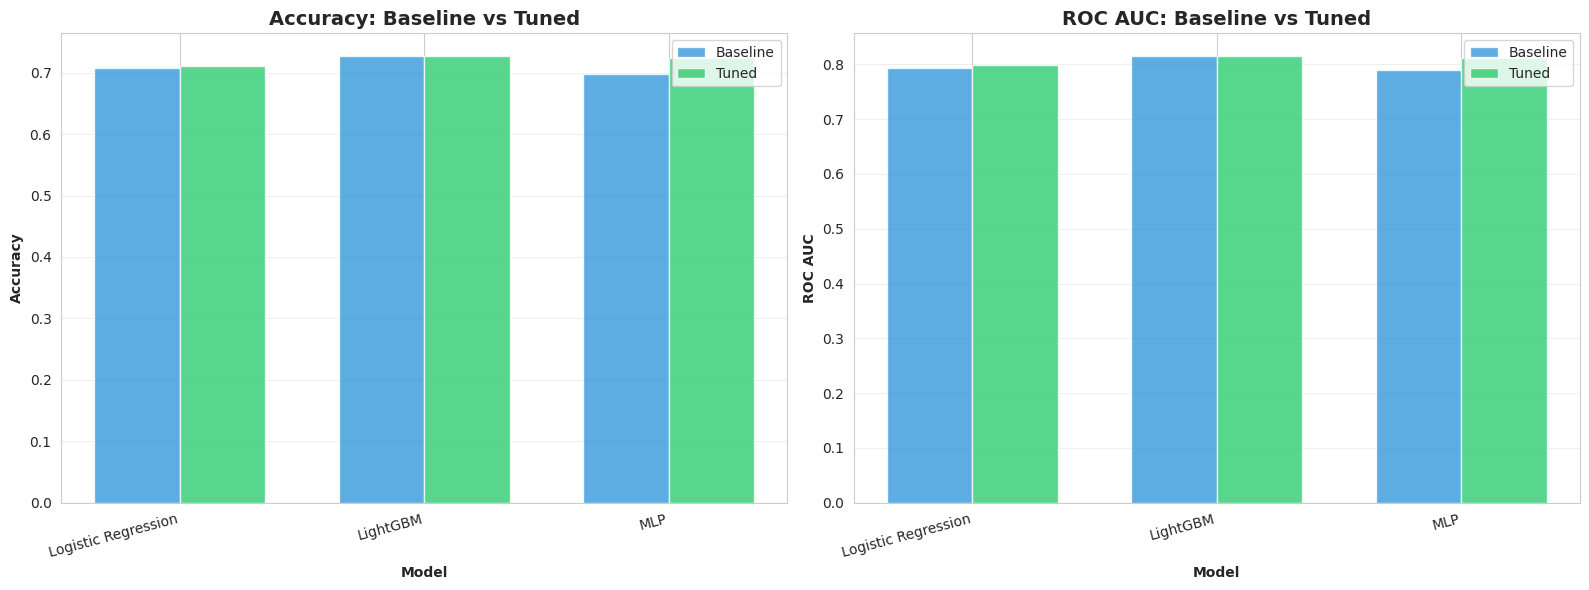

In [23]:
# Visualization: Before/After Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models = list(baseline_results.keys())
baseline_acc = [baseline_results[m]['accuracy'] for m in models]
tuned_acc = [tuned_results[m]['accuracy'] for m in models]

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, baseline_acc, width, label='Baseline', color='#3498db', alpha=0.8)
ax1.bar(x + width/2, tuned_acc, width, label='Tuned', color='#2ecc71', alpha=0.8)
ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# AUC comparison
baseline_auc = [baseline_results[m]['auc'] for m in models]
tuned_auc = [tuned_results[m]['auc'] for m in models]

ax2.bar(x - width/2, baseline_auc, width, label='Baseline', color='#3498db', alpha=0.8)
ax2.bar(x + width/2, tuned_auc, width, label='Tuned', color='#2ecc71', alpha=0.8)
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('ROC AUC', fontweight='bold')
ax2.set_title('ROC AUC: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Summary

This notebook demonstrates a complete machine learning workflow:

1. **Data Preparation**: Loaded and cleaned 100k records, created 3-class target
2. **Feature Engineering**: Created derived features (BMI, Training Load, Sleep Quality Score, etc.)
3. **Baseline Training**: Trained 3 models with default parameters
4. **Hyperparameter Tuning**: Optimized all 3 models using RandomizedSearchCV
5. **Evaluation**: Compared performance before and after tuning

**Key Findings:**
- All models showed improvement after hyperparameter tuning
- The tuned models are saved to `output/model/` for production use
- All 3 models can be used via the API by specifying the `model` parameter

**Next Steps:**
- Run `code/train.py` to train and save all models
- Use `app/main.py` to serve predictions via API
- Select models via `model=lgbm`, `model=lr`, or `model=mlp`
